In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.sequence import skipgrams

In [2]:
### READ DATA ###

df = pd.read_csv('dataset.csv')

df['LastUpdated'] = pd.to_datetime(df['LastUpdated'])
df['LastUpdated'] = df['LastUpdated'].dt.round('30min')
df = df.groupby(['SystemCodeNumber','LastUpdated']).mean().reset_index()
df['Hour'] = df['LastUpdated'].dt.hour + df['LastUpdated'].dt.minute.replace({0:0, 30:0.5})
df['DayOfWeek'] = df['LastUpdated'].dt.dayofweek  

df = df[
    (df['Occupancy']>=0) & (df['Capacity']>=0) & 
    (df['Hour'] >= 8) & (df['Hour'] <= 16.5)
]
df['OccupancyRate'] = ((100.0*df['Occupancy'])/df['Capacity']).clip(0,100)
df.reset_index(drop=True,inplace=True)

print(df.shape)
df.head()

(35416, 7)


,SystemCodeNumber,LastUpdated,Capacity,Occupancy,Hour,DayOfWeek,OccupancyRate
0,BHMBCCMKT01,2016-10-04 08:00:00,577.0,61.0,8.0,1,10.571924
1,BHMBCCMKT01,2016-10-04 08:30:00,577.0,64.0,8.5,1,11.091854
2,BHMBCCMKT01,2016-10-04 09:00:00,577.0,80.0,9.0,1,13.864818
3,BHMBCCMKT01,2016-10-04 09:30:00,577.0,107.0,9.5,1,18.544194
4,BHMBCCMKT01,2016-10-04 10:00:00,577.0,150.0,10.0,1,25.996534


In [3]:
### IMPUTE MISSING DATES ###

timestamps = pd.DataFrame(pd.date_range(
    df.LastUpdated.min(),df.LastUpdated.max(), freq='30min', name='LastUpdated'
))

df = pd.concat([
    timestamps.merge(g, on='LastUpdated', how='left').replace(
        {'SystemCodeNumber': {np.nan:_}}
    )
    for _,g in df.groupby(['SystemCodeNumber']) 
    if len(g) > 1000
], axis=0, ignore_index=True)

df['Hour'] = df['LastUpdated'].dt.hour + df['LastUpdated'].dt.minute.replace({0:0, 30:0.5})
df = df[(df['Hour'] >= 8) & (df['Hour'] <= 16.5)].copy()
df.reset_index(drop=True,inplace=True)

Text(0, 0.5, 'Occupancy')

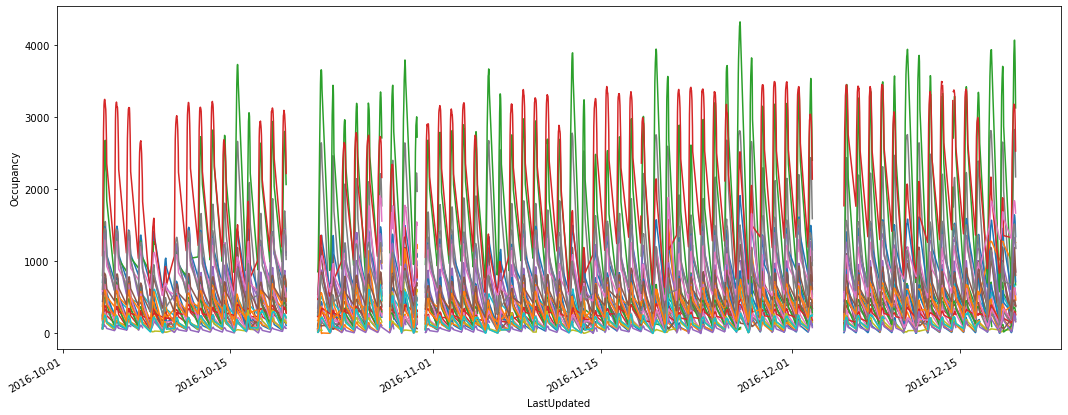

In [4]:
### PLOT OCCUPACY IN EACH PARKING AREA ###

df.pivot(
    index='LastUpdated', columns='SystemCodeNumber', values='Occupancy'
).plot(figsize=(18,7), legend=False)
plt.ylabel('Occupancy')

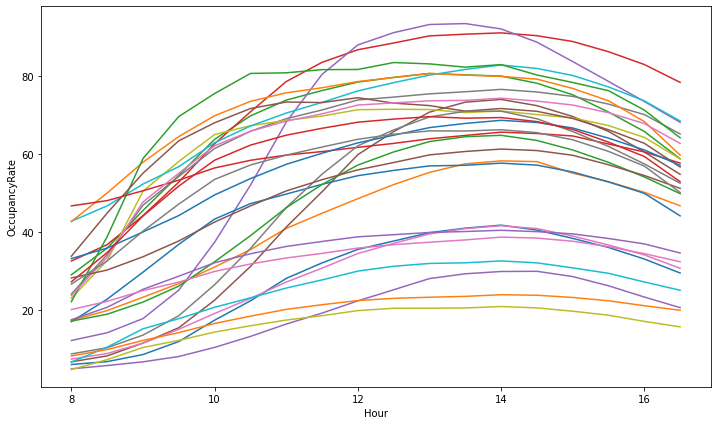

In [5]:
### PLOT OCCUPACYRATE IN EACH PARKING AREA BY HOUR ###

df.groupby(['SystemCodeNumber','Hour'])[['OccupancyRate']].mean().reset_index(level=1).groupby(
    level=0).plot(x='Hour', y='OccupancyRate', figsize=(12,7), ax=plt.gca(), legend=False)
plt.ylabel('OccupancyRate'); plt.show()

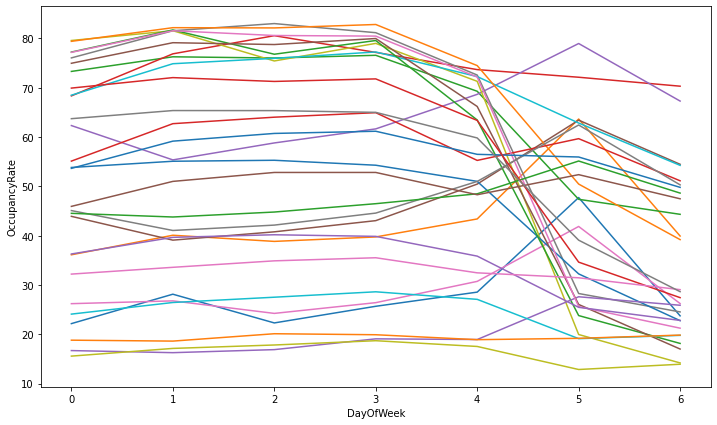

In [6]:
### PLOT OCCUPACYRATE IN EACH PARKING AREA BY DAY ###

df.groupby(['SystemCodeNumber','DayOfWeek'])[['OccupancyRate']].mean().reset_index(level=1).groupby(
    level=0).plot(x='DayOfWeek', y='OccupancyRate', figsize=(12,7), ax=plt.gca(), legend=False)
plt.ylabel('OccupancyRate'); plt.show()

In [7]:
### CREATE OCCUPACYRATE DF IN THE FORMAT: (TIMESTAMPS, PARKING AREA) ###

df = df.pivot(
    index='LastUpdated', columns='SystemCodeNumber', values='OccupancyRate'
)
df = df.fillna(-1)

df.shape

(1386, 28)

In [8]:
### DISCRETIZE OCCUPACYRATE TIMESERIES ### 

n_bins = 15
binning = lambda x: np.searchsorted(
    np.linspace(0,100,n_bins), x, side='rigth'
)

binned_df = pd.DataFrame(
    {c: binning(df[c]) for c in df}, index=df.index
)


binned_df.shape, binned_df.min().min(), binned_df.max().max()

((1386, 28), 0, 15)

In [9]:
### GENERATE COUPLES AND TARGETS TO TRAIN WORD2VEC ###

couples, labels = np.asarray([[],[]]).T, np.asarray([])
for c in binned_df:
    _couples, _labels = skipgrams(
        binned_df[c], vocabulary_size=n_bins+1, 
        window_size=n_bins//3, negative_samples=1.0, 
        shuffle=True, categorical=False, seed=33
    ) 
    _couples, _labels = np.asarray(_couples), np.asarray(_labels)
    _couples, _, _labels, _ = train_test_split(
        _couples, _labels, train_size=0.5, 
        random_state=33, shuffle=True
    )
    couples = np.concatenate([couples, _couples], axis=0)
    labels = np.append(labels, _labels)
    
couples.shape, labels.shape

((345292, 2), (345292,))

In [10]:
### DEFINE WORD2VEC AND FIT ###

tf.random.set_seed(33)

input_target = Input((1,))
input_context = Input((1,))
embedding = Embedding(n_bins+1, 32)
dot = Dot(axes=1, normalize=True)(
    [Flatten()(embedding(input_target)), 
     Flatten()(embedding(input_context))]
)
model = Model([input_target, input_context], dot)
model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss=BinaryCrossentropy(from_logits=True))

model.fit(x=[couples[:,[0]], couples[:,[1]]], y=labels, 
          callbacks=EarlyStopping(
              monitor='val_loss', min_delta=5e-4, patience=10,
              restore_best_weights=True, verbose=1
          ),
          epochs=100, batch_size=256, validation_split=0.2)

emb_model = Sequential([embedding, Flatten()])

Epoch 1/100
1080/1080 [==============================] - 2s 2ms/step - loss: 0.6467 - val_loss: 0.6261
Epoch 2/100
1080/1080 [==============================] - 2s 2ms/step - loss: 0.6280 - val_loss: 0.6114
Epoch 3/100
1080/1080 [==============================] - 2s 2ms/step - loss: 0.6150 - val_loss: 0.6021
Epoch 4/100
1080/1080 [==============================] - 2s 2ms/step - loss: 0.6075 - val_loss: 0.5967
Epoch 5/100
1080/1080 [==============================] - 2s 2ms/step - loss: 0.6035 - val_loss: 0.5936
Epoch 6/100
1080/1080 [==============================] - 2s 2ms/step - loss: 0.6013 - val_loss: 0.5917
Epoch 7/100
1080/1080 [==============================] - 2s 2ms/step - loss: 0.6001 - val_loss: 0.5905
Epoch 8/100
1080/1080 [==============================] - 2s 2ms/step - loss: 0.5995 - val_loss: 0.5897
Epoch 9/100
1080/1080 [==============================] - 2s 2ms/step - loss: 0.5991 - val_loss: 0.5892
Epoch 10/100
1080/1080 [==============================] - 2s 2ms/step - l

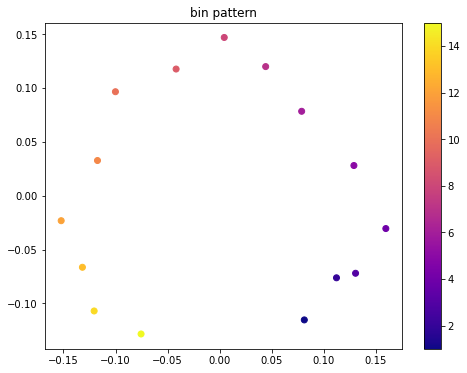

In [11]:
### PLOT BIN EMBEDDINGS ###

pca = PCA(n_components=2, random_state=33)
bin_arange = np.arange(1,n_bins+1).reshape(-1,1)
pca_trans = pca.fit_transform(
    emb_model.predict(bin_arange)
)

plt.figure(figsize=(8,6))
plt.scatter(*(pca_trans.T), c=bin_arange.ravel(), cmap='plasma')
plt.title('bin pattern');plt.colorbar()

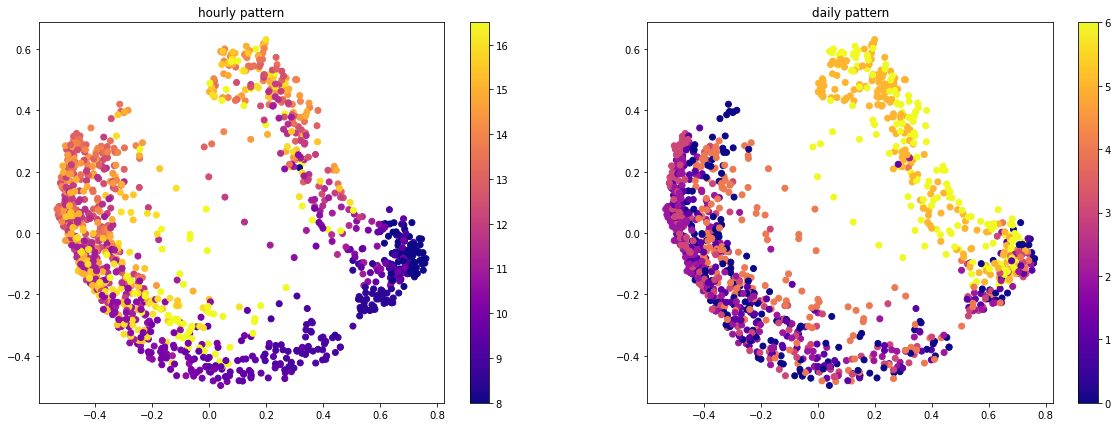

In [12]:
### PLOT EMBEDDED TIME SERIES BY HOUR AND DAY ###

color_h = df.index.hour + \
    pd.Series(df.index.minute).replace({0:0, 30:0.5})
color_d = df.index.weekday 

pca = PCA(n_components=2, random_state=33)
pca_trans = pca.fit_transform(
    np.hstack([emb_model.predict(binned_df[[c]]) for c in binned_df])
)

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.scatter(*(pca_trans.T), c=color_h, cmap='plasma')
plt.title('hourly pattern'); plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(*(pca_trans.T), c=color_d, cmap='plasma')
plt.title('daily pattern'); plt.colorbar()
plt.show()